In [3]:
%pylab inline
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

Populating the interactive namespace from numpy and matplotlib


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

## Index
* [Load and Inspect Data](#Load-and-Inspect-Data)
    * [Handle Age Outliers](#Handle-Age-Outliers)
    * [Inspect Country's distribution and its relationship with conversion](#Inspect-Country's-distribution-and-its-relationship-with-conversion)
    * [Inspect Age's distribution and its relationship with conversion](#Inspect-Age's-distribution-and-its-relationship-with-conversion)
* [Data Preprocessing](#Data-Preprocessing)
* [Classify by using Logistic Regression](#Classify-via-Logistic-Regression)

### Load and Inspect Data

In [9]:
inputfilename = "conversion_data.csv"
dataframe = pd.read_csv(inputfilename)
dataframe.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


#### Handle Age Outliers
'age' column has max=123, which are obvious abnormal. so we need to handle those outliers

In [10]:
dataframe.loc[dataframe.age>=100,:]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


if we just remove above two outliers, then what's the range of remaining ages?

In [11]:
dataframe.age[dataframe.age < 100].describe()

count    316198.000000
mean         30.569311
std           8.268958
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max          79.000000
Name: age, dtype: float64

we can see, min=17, max=79, which makes sense. since we have 316200 samples, but just two outliers, we can just remove these two outliers.

In [12]:
dataframe = dataframe.loc[dataframe.age < 100,:]

#### Inspect Country's distribution and its relationship with conversion

<AxesSubplot:>

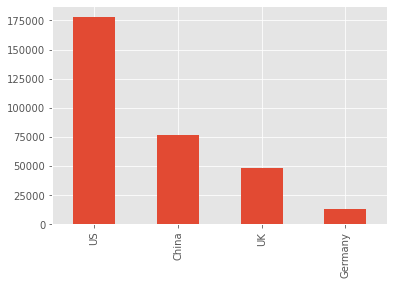

In [13]:
country_dist = dataframe.country.value_counts()

country_dist.plot(kind="bar")

In [14]:
convert_by_country_dist = dataframe.groupby("country")["converted"].mean()
convert_by_country_dist

country
China      0.001332
Germany    0.062428
UK         0.052612
US         0.037801
Name: converted, dtype: float64

<AxesSubplot:xlabel='country'>

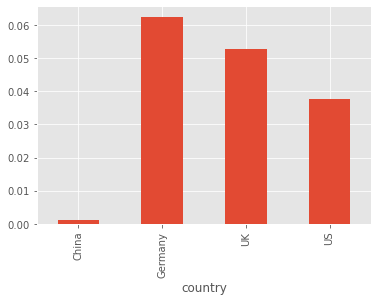

In [15]:
convert_by_country_dist.plot(kind="bar")

from above plots, at least we can see two problems:
1. there are lot of users from China, but the conversion rate is lowest
2. Conversion rate in German is very high, but there aren't a lot of users from German

#### Inspect Age's distribution and its relationship with conversion

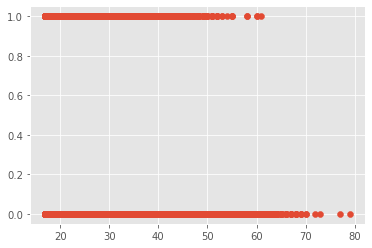

In [16]:
plt.scatter(dataframe.age,dataframe.converted)

from above plot, we can see there is nearly no "conversion" from users which are older than 60

### Data Preprocessing

In [17]:
dataframe.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


original dataframe has Categorical features 'country' and 'source', we use One-Hot-Encoding to transform them into numerical values

In [18]:
X = dataframe.loc[:,('country', 'age', 'new_user', 'source', 'total_pages_visited')]
X = pd.get_dummies(X)# OHE those categorical features

In [19]:
X.head()

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1


In [20]:
y = dataframe.converted
y.mean()

0.03225194340255157

from y's mean(), we know that, target value is very imbalanced, which reminds us should not use plain 'accurancy' as the metric to judge a classifier is good or not

then we need to split the whole dataset into 'training' dataset and 'test' dataset

In [21]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.333)

In [22]:
ytrain.mean(),ytest.mean()

(0.03218525964419831, 0.032385511045263736)

since both ytrain.mean() and ytest.mean() are similar to y.mean(), we can say, the splitting process doesn't import any bias

### Classify via Logistic Regression

In [23]:
## since the problem cares giving explanation on each factor
## it seems it would be better to use L1 penalty
## however, L1 penalty doesn't produce a sparse coeffecient, but AUC is much lower
## so I switch back to use L2 penalty
lrcv = LogisticRegressionCV(Cs = np.logspace(-3,3,7),
                            dual=False,
                            scoring='roc_auc',
                            max_iter=1000,
                            n_jobs=-1,
                            verbose=1)
lrcv.fit(Xtrain,ytrain)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished


LogisticRegressionCV(Cs=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                     max_iter=1000, n_jobs=-1, scoring='roc_auc', verbose=1)

In [24]:
lrcv.C_

array([10.])

In [25]:
lrcv.scores_

{1: array([[0.98296936, 0.98602732, 0.98675691, 0.98683494, 0.98684179,
         0.98684179, 0.98684179],
        [0.98200503, 0.98482456, 0.98526152, 0.98522306, 0.98522306,
         0.98520984, 0.98520984],
        [0.98275547, 0.98544777, 0.98615809, 0.98624124, 0.98624667,
         0.98624667, 0.98624667],
        [0.98232719, 0.98479214, 0.98544718, 0.98553221, 0.98553221,
         0.98553221, 0.98553221],
        [0.98182481, 0.9848486 , 0.98550371, 0.98553956, 0.98553963,
         0.98553963, 0.98553963]])}

In [26]:
lrcv.score(Xtrain,ytrain)

0.9858926964565992

In [27]:
lrcv.score(Xtest,ytest)

0.9863458569581345

In [28]:
1 - ytest.mean()

0.9676144889547362

In [30]:
ytest_predict = lrcv.predict(Xtest)
print(classification_report(y_true=ytest,y_pred=ytest_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    101884
           1       0.86      0.68      0.76      3410

    accuracy                           0.99    105294
   macro avg       0.93      0.84      0.88    105294
weighted avg       0.99      0.99      0.99    105294



from above, we know for "label=converted", if we use the default cutoff 0.5, we can have a high precision (0.85), but a not very good recall 0.68, which means we classify 32% converted user as non-converted. 

since our task is giving Sales team and Marking team some insights, so we don't need to tune the cutoff value now, since that won't affect the model. however, if, for example, if we care more about not losing a valued customer, so incorrectly classifing a converted user as non-converted will pay much, we need to lower down the cut-off probability to be 1, which will increase the recall with the price lower than precision.

since this is an imbalanced classification problem, if we group every record as 'NOT converted', we can still get 96.73 accuracy (1-ytest.mean()). since our LR model produces an accurancy as 98.57% on test dataset, which indicates it is a model which makes sense.

In [31]:
feat_importances = pd.DataFrame({"name":Xtrain.columns,"coef":lrcv.coef_[0]})
feat_importances = feat_importances[['name','coef']]# reorder the columns
feat_importances['importances'] = np.abs( feat_importances['coef'] )
feat_importances.sort_values(by="importances",inplace=True,ascending=False)
feat_importances

,name,coef,importances
3,country_China,-2.633306,2.633306
1,new_user,-1.706501,1.706501
4,country_Germany,1.029483,1.029483
5,country_UK,0.893619,0.893619
2,total_pages_visited,0.753144,0.753144
6,country_US,0.547921,0.547921
8,source_Direct,-0.160217,0.160217
0,age,-0.075231,0.075231
9,source_Seo,-0.007305,0.007305
7,source_Ads,0.005241,0.005241


from above model, we can draw below conclusion:
1. conversion among China users are very bad. from [inspection](#Inspect-Country's-distribution-and-its-relationship-with-conversion), we know that there are lot of users coming from China, but their conversion rate is very low. Consider China's economic and population, there is a huge opportunity if we target Chinese users and improve their conversion rate. we should consider whether our website has good Chinese translation and satisfy Chinese users' culture requirement.
2. conversion from Germany is good. but [inspection](#Inspect-Country's-distribution-and-its-relationship-with-conversion), we know that there isn't a lot of users from German. so it's a huge opportuntity for us to target German users. for example, put more advertisement in German.
3. old users have better conversion rate. we should keep touch with them, for example, send promotion email or coupons to old users.
4. age is a negative factor. the older the user is, the less likely he/she will convert. then we should figure out why young people loves the web pages and strengthen it. and also find out why older people doesn't like our web pages, and try to correct it.
5. total_pages_visited is a positive factor. the longer the user browse our web page, the more likely he/she will convert and buy something. then if we find some user browse a lot and didn't buy anything, we can send email to remaind them.